In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from matplotlib import colors

In [3]:
# function to load transition data
def load_processed_transition_data(year_start, year_end, shape=None, resolution=250, delta=None):
    path_bio = f"../data/processed/biomass/amazonia/{resolution}m/" 
    path_bio = path_bio + f"transition_{year_start}_{year_end}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            nodata = 255
            transition_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            transition_data = transition_data.squeeze().astype(bool)
            out_meta.update({"driver": "GTiff",
                 "height": transition_data.shape[0],
                 "width": transition_data.shape[1],
                 "transform": out_transform})
        else:
            transition_data = src.read(1).astype(bool)
    transition_data = torch.from_numpy(transition_data)
    if delta is not None:
        diff_x = int((transition_data.shape[1]%delta)/2 + delta)
        diff_y = int((transition_data.shape[0]%delta)/2 + delta)
        transition_data = torch.nn.functional.pad(transition_data, (diff_y, diff_y, diff_x, diff_x), value=False)
    return transition_data, out_meta

# get targets
output_px = 40
o = int(output_px/2)
data = torch.load(f'../data/processed/test_data.pt')
target_data, _ = load_processed_transition_data(2015, 2020, resolution=250, delta=360)
targets = []
for point in data:
    x = point[0]
    y = point[1]
    target = torch.sum(target_data[y-o:y+o, x-o:x+o])/(output_px**2)
    targets.append(target)
targets = torch.tensor(targets)

# get predictions
path = "../lightning_logs/version_32/"
predictions = torch.load(path + "test_predictions.pt")

# x_point, y_point, x_cluster, y_cluster, target | target | prediction
data_frame = torch.column_stack([data, targets, predictions])

In [4]:
data_frame[:5, 3:] # !target in data frame not correct (int problem)

tensor([[0.0000e+00, 1.0000e+00, 1.8750e-03, 3.1481e-02],
        [0.0000e+00, 2.0000e+00, 1.2500e-02, 2.7860e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0084e-02],
        [0.0000e+00, 1.0000e+00, 6.2500e-04, 3.6539e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2023e-02]])

In [5]:
data_frame.shape

torch.Size([14080, 7])

# Overall plots

In [6]:
target_layer = np.ones(target_data.shape) * -1
prediction_layer = np.ones(target_data.shape) * -1
for point in data_frame:
    x = int(point[0])
    y = int(point[1])
    target_layer[y-o:y+o, x-o:x+o] = point[-2]
    prediction_layer[y-o:y+o, x-o:x+o] = point[-1]

In [7]:
np.max(prediction_layer)

0.41078490018844604

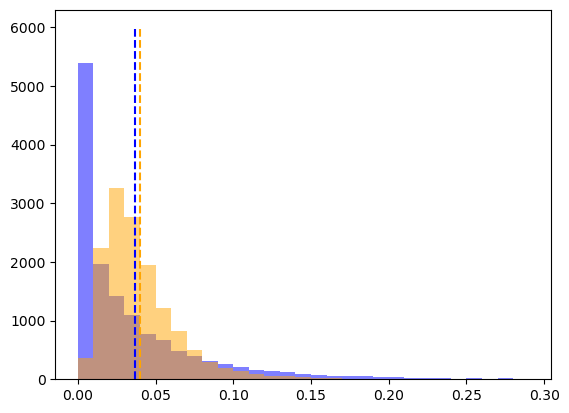

In [18]:
plt.hist(targets, alpha=0.5, bins=np.arange(0,0.3,0.01), color='blue')
plt.vlines(targets.mean(), 0, 6000, color='blue', linestyles='--')
plt.hist(predictions, alpha=0.5, bins=np.arange(0,0.3,0.01), color='orange')
plt.vlines(predictions.mean(), 0, 6000, color='orange', linestyles='--')
plt.show()

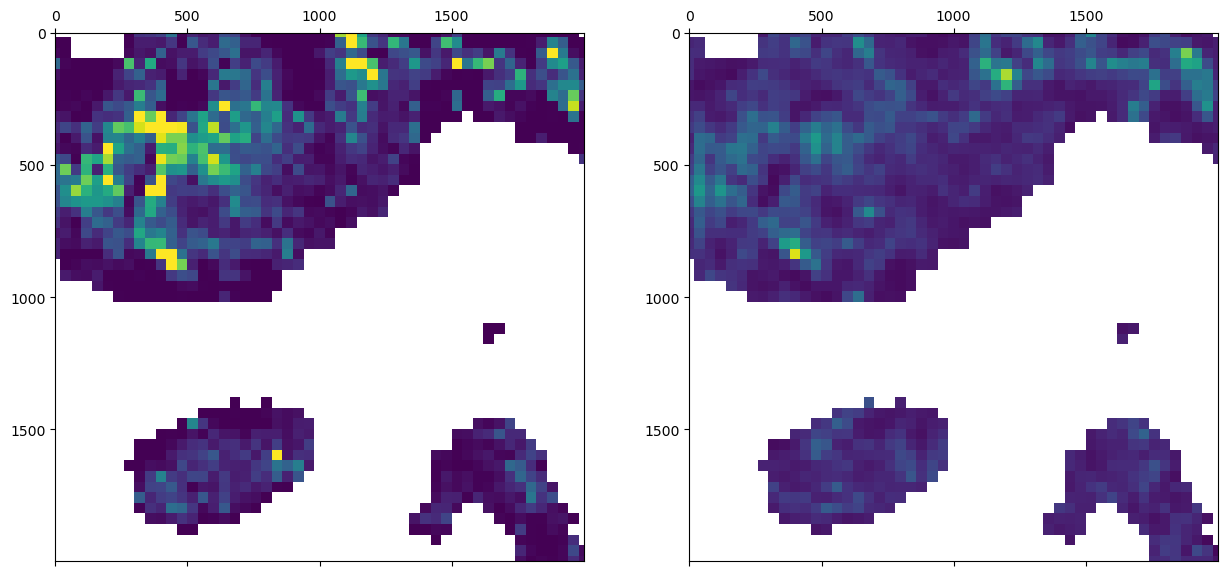

In [9]:
import matplotlib as mpl
cmap = mpl.colormaps['viridis']
cmap.set_under('white')

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs = axs.flatten()
axs[0].matshow(target_layer[8000:10000,4000:6000], vmin = 0, vmax = 0.3, cmap=cmap)
axs[1].matshow(prediction_layer[8000:10000,4000:6000], vmin = 0, vmax = 0.3, cmap=cmap)
plt.show()

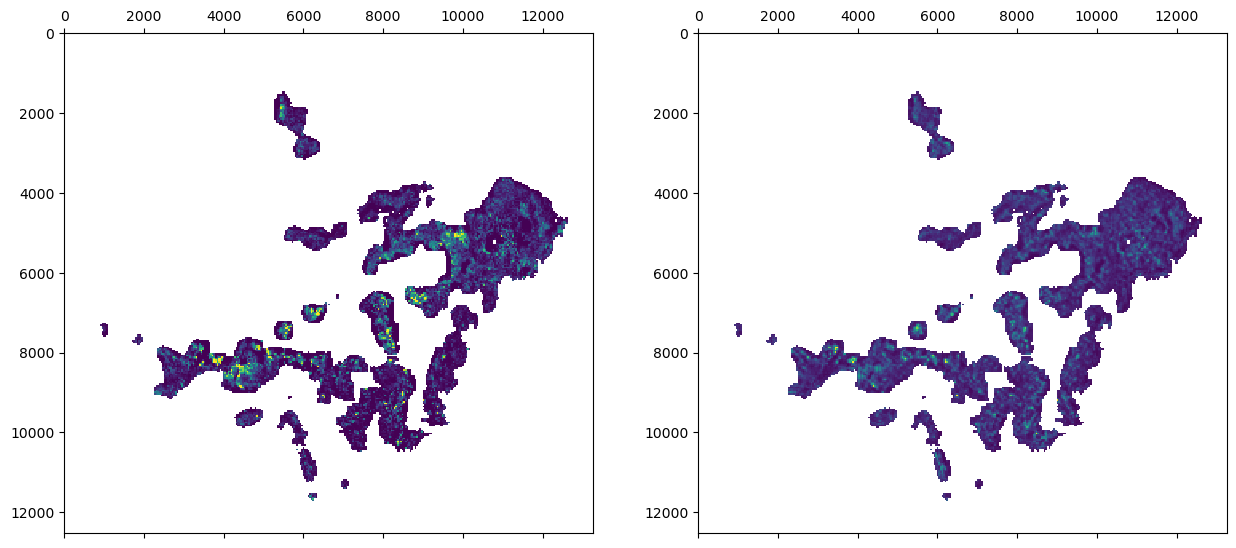

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs = axs.flatten()
axs[0].matshow(target_layer, vmin = 0, vmax = 0.3, cmap=cmap)
axs[1].matshow(prediction_layer, vmin = 0, vmax = 0.3, cmap=cmap)
plt.show()

# Investigating different output size

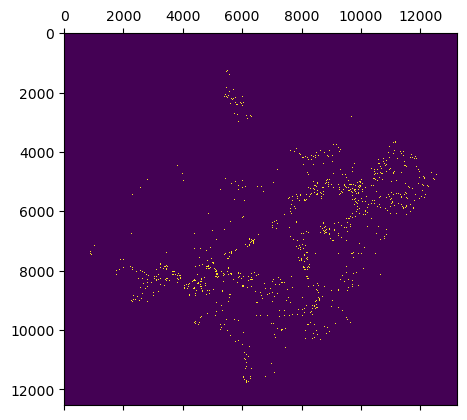

In [20]:
plt.matshow(target_data, vmin = 0, vmax = 1, cmap=cmap)
plt.show()

In [77]:
output_px_new = 100
o_new = int(output_px_new/2)
width = target_data.shape[1]
height = target_data.shape[0]
x = np.arange(0.5 * output_px_new, width - 0.5 * output_px_new, output_px_new)
y = np.arange(0.5 * output_px_new, height - 0.5 * output_px_new, output_px_new)
xv, yv = np.meshgrid(x, y)

target_layer_new = np.ones(target_data.shape) * -1
for x,y in zip(xv.flatten(),yv.flatten()):
    x = int(x)
    y = int(y)
    value = torch.sum(target_data[y-o_new:y+o_new, x-o_new:x+o_new]/(output_px_new**2))
    target_layer_new[y-o_new:y+o_new, x-o_new:x+o_new] = value
target_layer_new[target_layer==-1] = -1

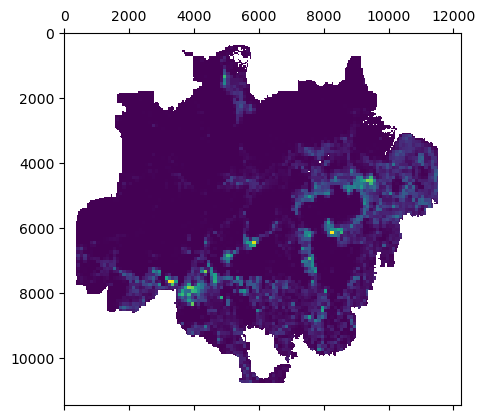

In [79]:
plt.matshow(target_layer_new, vmin = 0, vmax = 0.3, cmap=cmap)
plt.show()

# Old plots

In [20]:
# x_idx, y_idx, 2020, 2021
data_frame[(data_frame[:,2] == 0) & (data_frame[:,3] == 1)].shape

torch.Size([495, 5])

In [22]:
year_last_input = 2020
last_input = torch.load(f"../data/processed/biomass/30m/biomass_{year_last_input}.pt")
ground_truth = torch.load(f"../data/processed/biomass/30m/biomass_{year_last_input + 1}.pt")
prediction = last_input.clone()
probabilities = last_input.clone().to(float)

In [23]:
import matplotlib as mpl
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap.set_over('lightgrey')

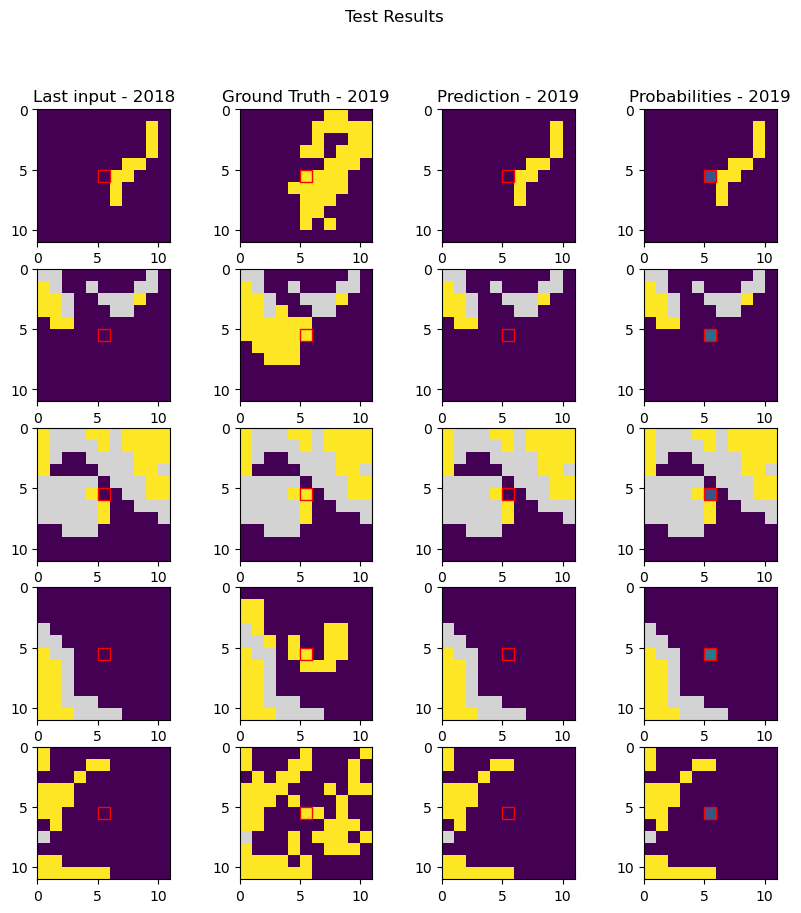

In [24]:
nr_points = 5
r = 5

# x_idx, y_idx, 2020, 2021, prediction
interesting_points = data_frame[(data_frame[:,2] == 0) & (data_frame[:,3] == 1)]
indices = torch.randperm(interesting_points.shape[0])
interesting_points = interesting_points[indices[:nr_points], :2]
interesting_points = interesting_points.numpy().astype(int)

fig, axs = plt.subplots(nr_points, 4, figsize=(10,10*int(nr_points/3)))
fig.suptitle("Test Results")

for idx, xy in enumerate(interesting_points):
    x = xy[0]; y = xy[1]
    for y_i in np.arange(y-r,y+r+1):
        for x_i in np.arange(x-r,x+r+1):
            model_predictions = data_frame[(data_frame[:,0] == x_i) & (data_frame[:,1] == y_i)]
            if len(model_predictions) == 1:
                prob = model_predictions[0,-1].item()
                probabilities[y_i,x_i] = prob
                prediction[y_i,x_i] = prob > 0.5

    if idx == 0:
        axs[idx,0].set_title("Last input - 2018")
        axs[idx,1].set_title("Ground Truth - 2019")
        axs[idx,2].set_title("Prediction - 2019")
        axs[idx,3].set_title("Probabilities - 2019")

    axs[idx,0].pcolormesh(last_input[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,0].add_patch(mpl.patches.Rectangle((r, r), 1, 1, fill=False, edgecolor='red'))
    axs[idx,0].invert_yaxis()
    axs[idx,0].set_aspect('equal', adjustable='box')

    axs[idx,1].pcolormesh(ground_truth[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,1].add_patch(mpl.patches.Rectangle((r, r), 1, 1, fill=False, edgecolor='red'))
    axs[idx,1].invert_yaxis()
    axs[idx,1].set_aspect('equal', adjustable='box')

    # axs[idx,2].pcolormesh(prediction[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,2].pcolormesh(prediction[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,2].add_patch(mpl.patches.Rectangle((r, r), 1, 1, fill=False, edgecolor='red'))
    axs[idx,2].invert_yaxis()
    axs[idx,2].set_aspect('equal', adjustable='box')

    axs[idx,3].pcolormesh(probabilities[y-r:y+r+1,x-r:x+r+1], norm=norm, cmap=cmap)
    axs[idx,3].add_patch(mpl.patches.Rectangle((r, r), 1, 1, fill=False, edgecolor='red'))
    axs[idx,3].invert_yaxis()
    axs[idx,3].set_aspect('equal', adjustable='box')

plt.show()